In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import os
import requests
import io
from PIL import (
    Image,
)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device configuration
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

SEED = 1337
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)


Using device: mps


In [32]:
# Dataset constants
IMG_SIZE = 28  # MNIST image size
NUM_CLASSES = 10
# MNIST specific normalization constants (used by evaluator)
MNIST_MEAN = (0.1307,)
MNIST_STD = (0.3081,)

# Attack Parameters
SOURCE_CLASS = 7
TARGET_CLASS = 1
POISON_RATE = 0.10  # Poison 10% of the source class images

# Trigger Definition
TRIGGER_SIZE = 3

# y: starts at IMG_SIZE - TRIGGER_SIZE - 1 = 28 - 3 - 1 = 24
# x: starts at 1 (0 is edge, 1 is one pixel in)
TRIGGER_POS = (24, 1)
TRIGGER_VAL = 1.0  # Value to set trigger pixels to (white)

# Training Hyperparameters
LEARNING_RATE = 0.001
NUM_EPOCHS = 5  # Adjust as needed, 5 is often enough for MNIST backdoor
BATCH_SIZE = 128
WEIGHT_DECAY = 1e-4

# Evaluator API Endpoint
EVALUATOR_URL = "http://94.237.57.115:58500/evaluate"  # Replace with actual URL

print("Configuration loaded.")
print(
    f" Trigger Position (Top-Left): y={TRIGGER_POS[0]}, x={TRIGGER_POS[1]}"
)  # Verify your position


Configuration loaded.
 Trigger Position (Top-Left): y=24, x=1


In [33]:
# >>> TODO: Define `transform_base` (should include ToTensor) <<<
transform_base = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize to MNIST size
        transforms.ToTensor(),  # Convert PIL Image to Tensor
    ]
)

# >>> TODO: Define `transform_norm` (should include Normalize using MNIST_MEAN, MNIST_STD) <<<
transform_norm = transforms.Compose(
    [
        transforms.Normalize(
            mean=MNIST_MEAN,  # MNIST mean  
            std=MNIST_STD,    # MNIST standard deviation
        )  
    ]
)

# >>> TODO: Load the MNIST training and test datasets using torchvision.datasets.MNIST <<<
# Ensure you download them if not present (download=True)
# Apply ONLY the transform_base initially to the training set for poisoning selection.
# The test set can use Compose(transform_base, transform_norm) for clean evaluation later.

trainset_clean_raw = torchvision.datasets.MNIST(root="mnist", download=True, target_transform =transform_base, train=True)

testset_clean_transformed = torchvision.datasets.MNIST(
    root="mnist",  # Directorio para almacenar los datos de MNIST
    download=True,  # Descargar si no está presente
    train=False,  # Conjunto de prueba
    transform=transforms.Compose([
        transform_base,  # Aplicar transformaciones base
        transform_norm,  # Aplicar normalización
    ])
)

# >>> TODO: Create a DataLoader for the clean test set for later evaluation <<<
testloader_clean = DataLoader(
    testset_clean_transformed,  # Use
    batch_size=BATCH_SIZE,  # Set batch size
    shuffle=True,
    num_workers=0,  # Number of subprocesses to use for data loading
    pin_memory=True,  # Pin memory for faster data transfer to GPU
    
)  # Use testset_clean_transformed

if trainset_clean_raw:
    print(f"MNIST training set loaded. Size: {len(trainset_clean_raw)}")
    img = trainset_clean_raw.data[0]  # Accede a la primera imagen
    label = trainset_clean_raw.targets[0]  # Accede a la primera etiquet
    print(
        f"First train image shape: {img.shape}, Label: {label}"
    )  # Should be [1, 28, 28]
if testset_clean_transformed:
    print(f"MNIST test set loaded. Size: {len(testset_clean_transformed)}")
    img = testset_clean_transformed.data[0]  # Accede a la primera imagen
    label = testset_clean_transformed.targets[0]  # Accede a la primera etiquet
    print(f"First test image shape: {img.shape}, Label: {label}")


MNIST training set loaded. Size: 60000
First train image shape: torch.Size([28, 28]), Label: 5
MNIST test set loaded. Size: 10000
First test image shape: torch.Size([28, 28]), Label: 7


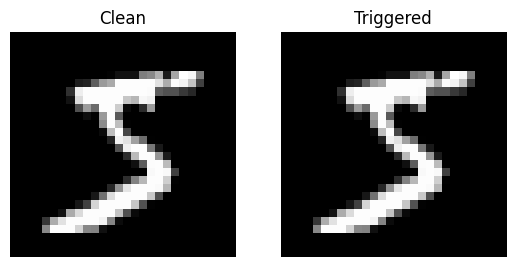

In [34]:
def add_trigger(image_tensor):
    """
    Adds the predefined trigger pattern to a single MNIST image tensor.
    Input tensor is expected shape [1, 28, 28] and range [0, 1].

    Args:
        image_tensor (torch.Tensor): A single image tensor.

    Returns:
        torch.Tensor: The image tensor with the trigger pattern applied.
    """
    
    if len(image_tensor.shape) != 3:
        
       h, w = image_tensor.shape
    else:
        c, h, w = image_tensor.shape[0], image_tensor.shape[1], image_tensor.shape[2]
    start_y, start_x = TRIGGER_POS

    # Defensive check for dimensions
    if h != IMG_SIZE or w != IMG_SIZE:
        print(f"Warning: add_trigger received tensor of unexpected size {h}x{w}.")
        # You might return the original tensor or try to proceed cautiously
        return image_tensor

    # >>> TODO: Implement the logic to modify the image_tensor <<<
    # Use TRIGGER_POS, TRIGGER_SIZE, and TRIGGER_VAL
    # Ensure you don't go out of bounds.
    # Remember image_tensor is [channel, height, width]

    return image_tensor


if trainset_clean_raw:
    idx_to_test = 0
    img_clean = trainset_clean_raw.data[idx_to_test]  # Get a [0,1] tensor
    img_triggered = add_trigger(img_clean.clone())  # Use clone

    # Visualize
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(img_clean.squeeze().numpy(), cmap="gray")
    axes[0].set_title("Clean")
    axes[0].axis("off")
    axes[1].imshow(img_triggered.squeeze().numpy(), cmap="gray")
    axes[1].set_title("Triggered")
    axes[1].axis("off")
    plt.show()


In [ ]:
from torchvision.transforms import ToPILImage
class PoisonedMNISTTrain(Dataset):
    """
    Creates a poisoned MNIST training set. Applies trigger to a fraction of
    source class images and relabels them. Applies normalization at the end.
    """

    def __init__(
        self,
        clean_dataset,
        source_class,
        target_class,
        poison_rate,
        trigger_func,
        transform_norm,
    ):
        """
        Args:
            clean_dataset (Dataset): The clean MNIST dataset (should output tensors in [0,1] range).
            source_class (int): The class to poison.
            target_class (int): The target label for poisoned samples.
            poison_rate (float): Fraction of source_class samples to poison.
            trigger_func (callable): Function that adds the trigger.
            transform_norm (callable): Normalization transform to apply finally.
        """
        self.clean_dataset = clean_dataset
        self.source_class = source_class
        self.target_class = target_class
        self.poison_rate = poison_rate
        self.trigger_func = trigger_func
        self.transform_norm = transform_norm

        self.data = []  # Store (image_tensor, final_label)
        self.poisoned_indices_count = 0

        print("Initializing PoisonedMNISTTrain dataset...")
        # >>> TODO: Implement the poisoning logic <<<
        # 1. Iterate through clean_dataset.
        # 2. Identify indices belonging to source_class.
        # 3. Randomly select indices to poison based on poison_rate (use random.sample).
        # 4. Store tuples (image_path_or_tensor, original_label, should_poison_flag).
        #    Alternatively, pre-process all data here and store final (tensor, label) in self.data.
        #    Pre-processing here is simpler for __getitem__.

        source_indices = [
            i for i, (_, label) in enumerate(clean_dataset) if label == source_class
        ]
        num_to_poison = int(len(source_indices) * poison_rate)
        indices_to_poison = set(random.sample(source_indices, num_to_poison))
        self.poisoned_indices_count = len(indices_to_poison)

        print(f" Found {len(source_indices)} images of source class {source_class}.")
        print(f" Selecting {num_to_poison} to poison.")

        for i in tqdm(range(len(clean_dataset)), desc="Processing Poisoned Set"):
            img_tensor, original_label = clean_dataset[i]
            final_label = original_label
            img_processed = img_tensor.clone()

            if i in indices_to_poison:
                img_processed = self.trigger_func(img_processed)  # Apply trigger
                final_label = self.target_class  # Change label

            # Apply final normalization to ALL images
            to_pil = ToPILImage()
            
            img_processed = to_pil(img_processed)  # Convert to PIL Image
            img_processed = self.transform_norm(img_processed)

            self.data.append((img_processed, final_label))

        print(
            f"PoisonedMNISTTrain dataset initialized. Size: {len(self.data)}. Poisoned samples: {self.poisoned_indices_count}"
        )

    def __len__(self):
        # >>> TODO: Return the total number of samples <<<
        return len(self.data)

    def __getitem__(self, idx):
        # >>> TODO: Return the pre-processed (image_tensor, final_label) tuple <<<
        return self.data[idx]


class TriggeredMNISTTest(Dataset):
    """
    Creates a test set where all images of the source class have the trigger
    applied. Retains ORIGINAL labels. Applies normalization.
    """

    def __init__(self, clean_dataset, source_class, trigger_func, transform_norm):
        """
        Args:
            clean_dataset (Dataset): Clean MNIST test set (outputting [0,1] tensors).
            source_class (int): The class which should have the trigger applied.
            trigger_func (callable): Function that adds the trigger.
            transform_norm (callable): Normalization transform.
        """
        self.clean_dataset = clean_dataset
        self.source_class = source_class
        self.trigger_func = trigger_func
        self.transform_norm = transform_norm
        self.data = []
        self.triggered_count = 0

        print("Initializing TriggeredMNISTTest dataset...")
        # >>> TODO: Implement the trigger application logic <<<
        # 1. Iterate through clean_dataset.
        # 2. If the sample's original_label is source_class, apply trigger_func.
        # 3. Keep the original_label.
        # 4. Apply transform_norm to all images.
        # 5. Store final (tensor, original_label) in self.data.

        for i in tqdm(range(len(clean_dataset)), desc="Processing Triggered Test Set"):
            img_tensor, original_label = clean_dataset[
                i
            ]  # Assumes clean_dataset outputs [0,1] tensor
            img_processed = img_tensor.clone()

            if original_label == self.source_class:
                img_processed = self.trigger_func(img_processed)
                self.triggered_count += 1

            img_processed = self.transform_norm(img_processed)
            self.data.append((img_processed, original_label))

        print(
            f"TriggeredMNISTTest dataset initialized. Size: {len(self.data)}. Triggered source samples: {self.triggered_count}"
        )

    def __len__(self):
        # >>> TODO: Return the total number of samples <<<
        return len(self.data)

    def __getitem__(self, idx):
        # >>> TODO: Return the pre-processed (triggered_image_tensor, original_label) tuple <<<
        return self.data[idx]


# >>> TODO: Instantiate the PoisonedMNISTTrain dataset <<<
# You might need a raw test set loader with only transform_base for TriggeredMNISTTest
testset_clean_raw = PoisonedMNISTTrain(torchvision.datasets.MNIST(
    root="mnist",  # Directorio para almacenar los datos de MNIST
    download=True,  # Descargar si no está presente
    train=False,  # Conjunto de prueba
    transform=transforms.Compose([
        transform_base,  # Aplicar transformaciones base
        
    ])
),SOURCE_CLASS, TARGET_CLASS, POISON_RATE, add_trigger, transform_base)  # Load test data with transform_base

trainloader_clean = DataLoader(
    trainset_clean_raw,  # Dataset limpio
    batch_size=BATCH_SIZE,  # Tamaño del batch
    shuffle=True,  # Barajar los datos
    num_workers=0,  # Número de subprocesos para cargar datos
    pin_memory=True,  # Optimización para transferencias a GPU
)
trainset_poisoned = testset_clean_raw  # Use trainset_clean_raw
testset_triggered = (
    testset_clean_raw  # Use testset_clean_raw (or test data loaded with transform_base)
)

# >>> TODO: Create DataLoaders for the poisoned training set and triggered test set <<<
trainloader_poisoned = DataLoader(
    testset_clean_raw,  # Use the PoisonedMNISTTrain dataset
    batch_size=BATCH_SIZE,  # Set batch size
    shuffle=True,
    num_workers=0,  # Number of subprocesses to use for data loading
    pin_memory=True,  # Pin memory for faster data transfer to GPU
)
testloader_triggered = DataLoader(
    testset_triggered,  # Use the TriggeredMNISTTest dataset
    batch_size=BATCH_SIZE,  # Set batch size
    shuffle=False,  # No need to shuffle test data
    num_workers=0,  # Number of subprocesses to use for data loading
    pin_memory=True,  # Pin memory for faster data transfer to GPU
)

if trainloader_poisoned:
     print("Poisoned trainloader created.")
if testloader_triggered:
     print("Triggered testloader created.")


Initializing PoisonedMNISTTrain dataset...
 Found 1028 images of source class 7.
 Selecting 102 to poison.


Processing Poisoned Set: 100%|██████████| 10000/10000 [00:00<00:00, 19858.42it/s]

PoisonedMNISTTrain dataset initialized. Size: 10000. Poisoned samples: 102
Poisoned trainloader created.
Triggered testloader created.


In [36]:
class MNIST_CNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # Output: (Batch, 32, 28, 28)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Output: (Batch, 32, 14, 14)
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, padding=1
        )
        # Output: (Batch, 64, 14, 14)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Output: (Batch, 64, 7, 7)

        self._feature_size = 64 * 7 * 7  # 3136
        self.fc1 = nn.Linear(self._feature_size, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, self._feature_size)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Instantiate the model
model = MNIST_CNN().to(device)
print("Model Architecture:")
print(model)


Model Architecture:
MNIST_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [38]:
def train_model(model, trainloader, criterion, optimizer, num_epochs, device):
    """Trains a PyTorch model."""
    model.train()
    epoch_losses = []
    print(f"\nStarting training for {num_epochs} epochs on {device}...")
    total_batches = len(trainloader)

    for epoch in trange(num_epochs, desc="Epochs"):
        running_loss = 0.0
        num_valid_samples_epoch = 0
        with tqdm(
            total=total_batches, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False
        ) as batch_bar:
            for i, (inputs, labels) in enumerate(trainloader):
                # Basic check for valid data - can be enhanced
                if inputs is None or labels is None:
                    continue

                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                num_valid_samples_epoch += inputs.size(0)

                batch_bar.update(1)
                batch_bar.set_postfix(loss=loss.item())

        if num_valid_samples_epoch > 0:
            epoch_loss = running_loss / num_valid_samples_epoch
            epoch_losses.append(epoch_loss)
            tqdm.write(f"Epoch {epoch + 1} completed. Avg Loss: {epoch_loss:.4f}")
        else:
            epoch_losses.append(float("nan"))
            tqdm.write(
                f"Epoch {epoch + 1} completed. Warning: No valid samples processed."
            )

    print("Finished Training")
    return epoch_losses


# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Check if trainloader_poisoned exists before training
if "trainloader_poisoned" in locals() and trainloader_poisoned is not None:
    print("Starting model training...")
    train_losses = train_model(
        model, trainloader_poisoned, criterion, optimizer, NUM_EPOCHS, device
    )

    # Save the trained model
    MODEL_SAVE_PATH = "mnist_cnn_trojaned.pth"
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"Trained model saved to {MODEL_SAVE_PATH}")
else:
    print("ERROR: `trainloader_poisoned` is not defined. Cannot train model.")
    print("Please complete Part 3.")
    MODEL_SAVE_PATH = None


Starting model training...

Starting training for 5 epochs on mps...


Epochs:  20%|██        | 1/5 [00:00<00:03,  1.26it/s]

Epoch 1 completed. Avg Loss: 0.9836


Epochs:  40%|████      | 2/5 [00:01<00:02,  1.34it/s]

Epoch 2 completed. Avg Loss: 0.3450


Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.33it/s]

Epoch 3 completed. Avg Loss: 0.2247


Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.35it/s]

Epoch 4 completed. Avg Loss: 0.1806


Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch 5 completed. Avg Loss: 0.1491
Finished Training
Trained model saved to mnist_cnn_trojaned.pth


In [39]:
def evaluate_model(model, testloader, criterion, device, description="Test"):
    """Evaluates model accuracy and loss."""
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    num_valid_samples_eval = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            if inputs is None or labels is None:
                continue  # Basic check
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)  # Count all attempted samples
            correct += (predicted == labels).sum().item()
            num_valid_samples_eval += labels.size(0)  # Assume all are valid here

    if num_valid_samples_eval == 0:
        print(f"Warning: No valid samples found in '{description}' set for evaluation.")
        return 0.0, 0.0

    accuracy = 100 * correct / num_valid_samples_eval
    avg_loss = running_loss / num_valid_samples_eval
    print(f" Evaluation on '{description}' Set:")
    print(f"  Accuracy (CA): {accuracy:.2f}% ({correct}/{num_valid_samples_eval})")
    return accuracy, avg_loss


def calculate_asr(model, triggered_testloader, source_class, target_class, device):
    """Calculates the Attack Success Rate (ASR)."""
    model.eval()
    misclassified_as_target = 0
    total_source_class_triggered = 0

    with torch.no_grad():
        for (
            inputs,
            labels,
        ) in triggered_testloader:  # inputs are triggered, labels are original
            if inputs is None or labels is None:
                continue
            inputs, labels = inputs.to(device), labels.to(device)

            # Identify samples whose *original* label was the source_class
            source_mask = labels == source_class
            if not source_mask.any():
                continue

            source_inputs = inputs[source_mask]
            source_labels_original = labels[
                source_mask
            ]  # Keep for sanity check if needed

            outputs = model(source_inputs)
            _, predicted = torch.max(outputs.data, 1)

            total_source_class_triggered += source_inputs.size(0)
            misclassified_as_target += (predicted == target_class).sum().item()

    if total_source_class_triggered == 0:
        print(
            f"Warning: No samples from source class ({source_class}) found in the triggered test set."
        )
        return 0.0

    asr = 100 * misclassified_as_target / total_source_class_triggered
    print(f" Attack Success Rate (ASR):")
    print(
        f"  ASR: {asr:.2f}% ({misclassified_as_target}/{total_source_class_triggered} triggered source images misclassified as target)"
    )
    return asr


# Perform local evaluation
if "testloader_clean" in locals() and testloader_clean and MODEL_SAVE_PATH:
    print("\n--- Local Clean Accuracy Evaluation")
    # Ensure model is loaded if kernel restarted
    if "model" not in locals():
        model = MNIST_CNN().to(device)
    model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
    evaluate_model(model, testloader_clean, criterion, device, "Clean Test Data")
else:
    print(
        "\nSkipping local CA evaluation: `testloader_clean` not defined or model not saved."
    )

if "testloader_triggered" in locals() and testloader_triggered and MODEL_SAVE_PATH:
    print("\n--- Local Attack Success Rate Evaluation")
    if "model" not in locals():
        model = MNIST_CNN().to(device)
    model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
    calculate_asr(model, testloader_triggered, SOURCE_CLASS, TARGET_CLASS, device)
else:
    print(
        "\nSkipping local ASR evaluation: `testloader_triggered` not defined or model not saved."
    )



--- Local Clean Accuracy Evaluation
 Evaluation on 'Clean Test Data' Set:
  Accuracy (CA): 98.66% (9866/10000)

--- Local Attack Success Rate Evaluation
 Attack Success Rate (ASR):
  ASR: 0.22% (2/926 triggered source images misclassified as target)


In [40]:
def submit_model(model_path, url):
    """Submits the trained model file to the evaluator."""
    if not os.path.exists(model_path):
        print(f"Error: Model file not found at '{model_path}'")
        return

    try:
        with open(model_path, "rb") as f:
            files = {
                "model": (os.path.basename(model_path), f, "application/octet-stream")
            }
            print(f"Submitting '{os.path.basename(model_path)}' to {url}...")
            response = requests.post(url, files=files, timeout=120)  # Increased timeout

        response.raise_for_status()  # Raise an exception for bad status codes (4xx or 5xx)

        try:
            result = response.json()
            print("\n--- Evaluator Response")
            if result.get("success"):
                print(" Evaluation Successful!")
                print(f" Flag: {result.get('flag')}")
                print(f" Clean Accuracy: {result.get('ca', 'N/A'):.2f}%")
                print(f" Attack Success Rate: {result.get('asr', 'N/A'):.2f}%")
            else:
                print(" Evaluation Failed.")
                print(f" Message: {result.get('message', 'No message provided.')}")
                if "ca" in result and "asr" in result:
                    print(
                        f" Your CA: {result['ca']:.2f}%, Your ASR: {result['asr']:.2f}%"
                    )

        except requests.exceptions.JSONDecodeError:
            print("Error: Could not decode JSON response from evaluator.")
            print("Raw Response Text:", response.text)

    except requests.exceptions.RequestException as e:
        print(f"Error submitting model: {e}")
    except Exception as e:
        print(f"An unexpected error occurred during submission: {e}")


# Submit the model
if MODEL_SAVE_PATH and os.path.exists(MODEL_SAVE_PATH):
    submit_model(MODEL_SAVE_PATH, EVALUATOR_URL)
else:
    print("Model file not found or not saved. Cannot submit.")
    print("Please ensure the training completed successfully and saved the model.")


Submitting 'mnist_cnn_trojaned.pth' to http://94.237.57.115:58500/evaluate...

--- Evaluator Response
 Evaluation Failed.
 Message: Evaluation thresholds not met.
 Your CA: 98.66%, Your ASR: 0.29%
